In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("../data/lego.population.csv", sep = ",", encoding = "latin1")
df.head()
df

,Item_Number,Set_Name,Theme,Pieces,Price,Amazon_Price,Year,Ages,Pages,Minifigures,Packaging,Weight,Unique_Pieces,Availability,Size
0,41916,Extra Dots - Series 2,DOTS,109.0,$3.99,$3.44,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
1,41908,Extra Dots - Series 1,DOTS,109.0,$3.99,$3.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
2,11006,Creative Blue Bricks,Classic,52.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,28.0,Retail,Small
3,11007,Creative Green Bricks,Classic,60.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,36.0,Retail,Small
4,41901,Funky Animals Bracelet,DOTS,33.0,$4.99,$4.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,10.0,Retail,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,45678,SPIKE Prime Set,LEGO® Education,528.0,$329.95,NaN,2020,Ages_10+,NaN,2.0,NaN,NaN,108.0,NaN,Small
1300,71367,Mario's House & Yoshi,LEGO® Super Mario,205.0,$29.99,NaN,2020,Ages_6+,NaN,2.0,Box,NaN,114.0,Retail,Small
1301,71368,Toad's Treasure Hunt,LEGO® Super Mario,464.0,$69.99,NaN,2020,Ages_8+,NaN,4.0,Box,NaN,195.0,Retail,Small
1302,71369,Bowser's Castle Boss Battle,LEGO® Super Mario,1010.0,$99.99,NaN,2020,Ages_8+,NaN,NaN,Box,NaN,346.0,Retail,Small


In [6]:
# fjerner forklaringsvariabler vi ikke trenger
df2 = df[['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages', 'Minifigures', 'Unique_Pieces', 'Amazon_Price', 'Year', 'Ages']]

# fjerner observasjoner med manglende datapunkter (I virkeligheten er det risikabelt å fjerne manglende data punkter uten videre. Dette kan påvirke resultatene på en måte som er vanskelig å avdekke.)
# Det finnes metoder som tar hensyn til tomme dataceller men dette prosjektet har ikke dette som en del av oppgaven, slik at vi velger å ta utgangspunkt i det originale datasettet.
df2 = df2.dropna()

# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2['Theme'] = df2['Theme'].astype(str)
df2['Theme'] = df2['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)

# fjerner dollartegn og trademark-tegn fra datasettet
df2['Price'] = df2['Price'].str.replace('\$', '', regex = True)

# og gjør så prisen om til float
df2['Price'] = df2['Price'].astype(float)

df2

#df2['Age'] = np.where(df2['Ages'].isin(['Ages_10+', 'Ages_10+']), 10, np.where(df2['Ages'].isin(['Ages_6+']), 6, np.where(df2['Ages'].isin(['Ages_8+']), 8, 0)))
#df2.groupby(['LegoGroup']).size().reset_index(name = 'Count')

<>:13: SyntaxWarning: invalid escape sequence '\$'
<>:13: SyntaxWarning: invalid escape sequence '\$'
C:\Users\vikto\AppData\Local\Temp\ipykernel_22204\3961998781.py:13: SyntaxWarning: invalid escape sequence '\$'
  df2['Price'] = df2['Price'].str.replace('\$', '', regex = True)


,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Amazon_Price,Year,Ages
13,Stephanie's Summer Heart Box,Friends,95.0,7.99,40.0,1.0,52.0,$7.71,2019,Ages_6+
16,Woody & RC,Disney,69.0,9.99,28.0,1.0,36.0,$7.99,2019,Ages_4+
17,Mia's Summer Heart Box,Friends,85.0,7.99,36.0,1.0,41.0,$7.99,2019,Ages_6+
18,Olivia's Summer Heart Box,Friends,93.0,7.99,40.0,2.0,48.0,$7.99,2019,Ages_6+
19,Police Patrol Car,City,92.0,9.99,36.0,1.0,52.0,$8.35,2019,Ages_5+
...,...,...,...,...,...,...,...,...,...,...
819,Roller Coaster,Creator Expert,4124.0,379.99,440.0,11.0,556.0,$379.95,2018,Ages_16+
821,Hogwarts Castle,Harry Potter,6020.0,399.99,636.0,28.0,624.0,$399.99,2018,Ages_16+
822,NINJAGO City Docks,NINJAGO,3553.0,229.99,380.0,14.0,690.0,$440.00,2018,Ages_12+
824,Betrayal at Cloud City,Star Wars,2812.0,349.99,388.0,19.0,676.0,$668.18,2018,Ages_14+


In [36]:
df2['Amazon_Price'] = df2['Amazon_Price'].replace('$', '').astype(float)

print(df2.head())

# Logistic regression model
formula = "LegoGroup ~ Amazon_Price + Pieces + Pages + Minifigures + Unique_Pieces + Year"
model = smf.logit(formula, data=df2)
result = model.fit()

# Display the summary
print(result.summary())

                        Set_Name    Theme  Pieces  Price  Pages  Minifigures  \
13  Stephanie's Summer Heart Box  Friends    95.0   7.99   40.0          1.0   
16                    Woody & RC   Disney    69.0   9.99   28.0          1.0   
17        Mia's Summer Heart Box  Friends    85.0   7.99   36.0          1.0   
18     Olivia's Summer Heart Box  Friends    93.0   7.99   40.0          2.0   
19             Police Patrol Car     City    92.0   9.99   36.0          1.0   

    Unique_Pieces  Amazon_Price  Year     Ages  LegoGroup  
13           52.0          7.71  2019  Ages_6+          1  
16           36.0          7.99  2019  Ages_4+          0  
17           41.0          7.99  2019  Ages_6+          1  
18           48.0          7.99  2019  Ages_6+          1  
19           52.0          8.35  2019  Ages_5+          1  
Optimization terminated successfully.
         Current function value: 0.644794
         Iterations 7
                           Logit Regression Results      

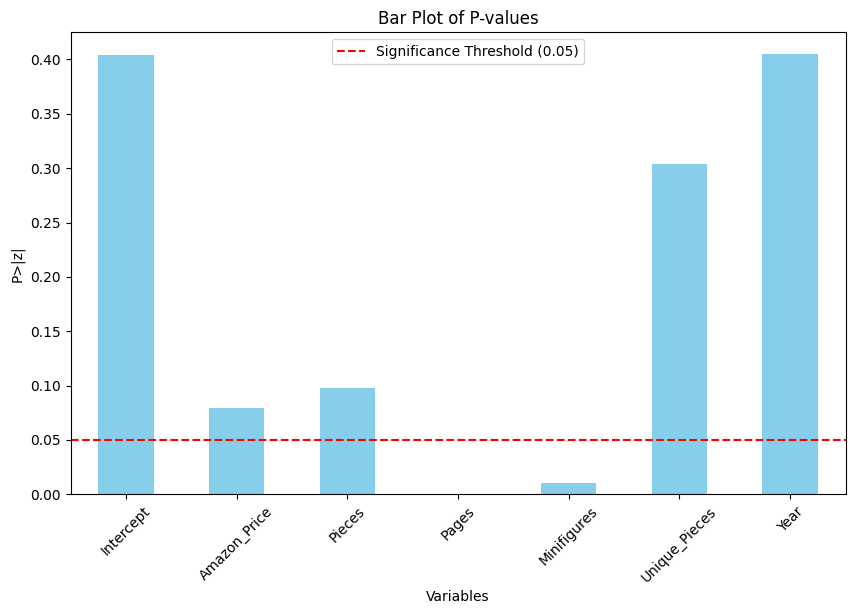

In [37]:
p_values = result.pvalues

# Create a bar plot for p-values
plt.figure(figsize=(10, 6))
p_values.plot(kind='bar', color='skyblue')
plt.axhline(0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.xlabel('Variables')
plt.ylabel('P>|z|')
plt.title('Bar Plot of P-values')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [58]:
formel = 'Price ~ LegoGroup + Pages + Minifigures + Theme'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     54.89
Date:                Thu, 09 Nov 2023   Prob (F-statistic):          3.17e-147
Time:                        11:45:55   Log-Likelihood:                -2920.1
No. Observations:                 622   AIC:                             5900.
Df Residuals:                     592   BIC:                             6033.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -13.9460      7.424     -1.878      0.061     -28.527       0.635
Theme[T.City]                -11.3994      3.487     -3.269      0.001     -18.249      -4.550
Theme[T.Classic]              14.1667     14.681      0.965      0.335     -14.667      43.000
Theme[T.Creator 3-in-1]      -57.4000      6.829     -8.405      0.000     -70.812     -43.988
Theme[T.Creator Expert]       78.6972      9.267      8.492      0.000      60.497      96.897
Theme[T.DC]                   11.7112     12.024      0.974      0.330     -11.904      35.326
Theme[T.DUPLO]                33.6451      5.503      6.114      0.000      22.837      44.453
Theme[T.Disney]               12.9407      8.751      1.479      0.140      -4.246      30.127
Theme[T.Friends]              -0.7272      3.565     -0.204      0.838      -7.728       6.274
Theme[T.Harry Potter]          5.7094      9.957      0.573      0.567     -13.847      25.265
Theme[T.Hidden Side]         -12.7942      6.175     -2.072      0.039     -24.922      -0.666
Theme[T.Ideas]               -10.5971      9.815     -1.080      0.281     -29.874       8.680
Theme[T.Juniors]               1.6582      7.605      0.218      0.827     -13.279      16.595
Theme[T.Jurassic World]       12.9298      9.935      1.301      0.194      -6.583      32.443
Theme[T.LEGO Frozen 2]         2.9837     12.581      0.237      0.813     -21.725      27.693
Theme[T.Marvel]                1.0378      8.425      0.123      0.902     -15.509      17.585
Theme[T.Minecraft]            -0.2527      9.367     -0.027      0.978     -18.650      18.145
Theme[T.Minions]             -17.5829     20.525     -0.857      0.392     -57.894      22.728
Theme[T.NINJAGO]              -1.6891      3.824     -0.442      0.659      -9.200       5.822
Theme[T.Overwatch]            -3.2207     12.583     -0.256      0.798     -27.934      21.493
Theme[T.Powerpuff Girls]       0.6450     20.512      0.031      0.975     -39.639      40.929
Theme[T.Speed Champions]      -5.9675      6.504     -0.918      0.359     -18.741       6.806
Theme[T.Spider-Man]           13.8996     20.505      0.678      0.498     -26.372      54.171
Theme[T.Star Wars]            19.3935      7.887      2.459      0.014       3.903      34.884
Theme[T.Stranger Things]      48.9502     28.278      1.731      0.084      -6.588     104.488
Theme[T.THE LEGO MOVIE 2]     -0.5512      6.019     -0.092      0.927     -12.372      11.270
Theme[T.Trolls World Tour]    -5.1512     13.245     -0.389      0.697     -31.165      20.862
Theme[T.Unikitty]            -27.0628     11.618     -2.329      0.020     -49.880      -4.245
LegoGroup                     -0.0211      7.080     -0.003      0.998     -13.926      13.884
Pages                          0.4894      

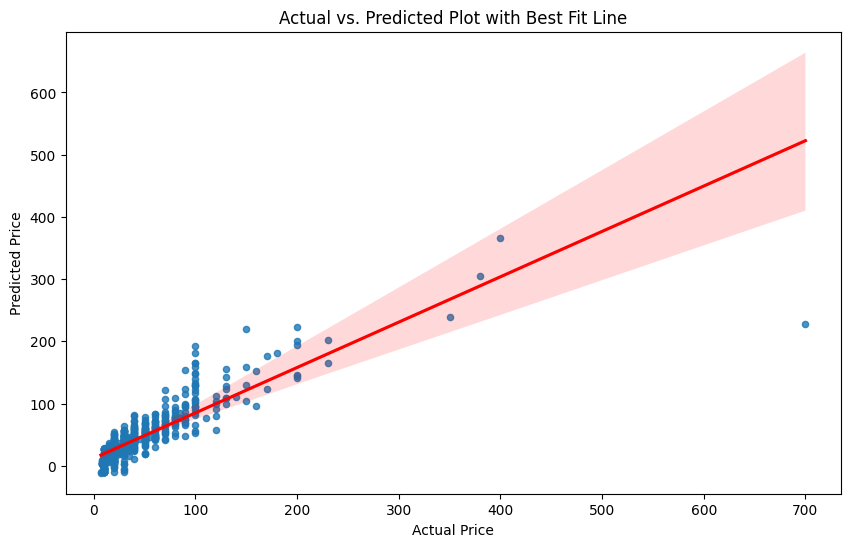

In [59]:
predicted_values = resultat.predict()

# Create the plot
plt.figure(figsize=(10, 6))
sns.regplot(x=df2['Price'], y=predicted_values, scatter_kws={'s': 20}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Plot with Best Fit Line')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

ValueError: operands could not be broadcast together with shapes (622,) (31,) 

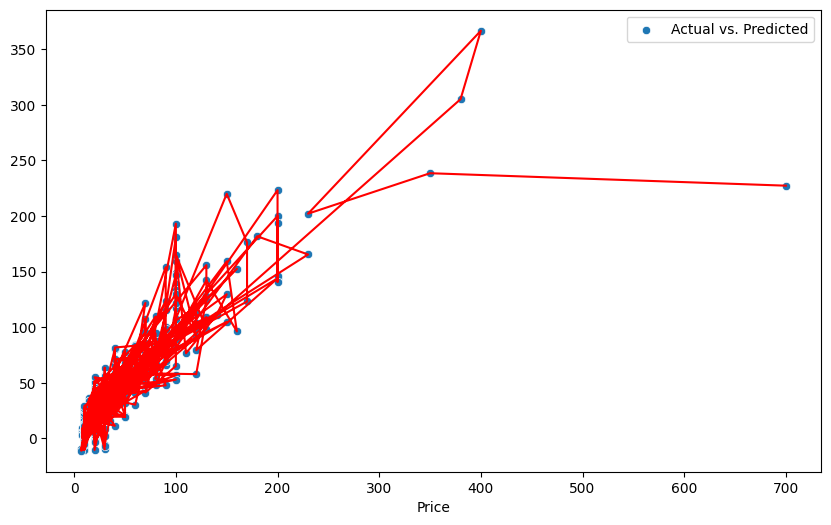

In [60]:
predicted_values = resultat.predict()

# Get confidence intervals for the regression coefficients
ci = resultat.conf_int(0.05)

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs. predicted values
sns.scatterplot(x=df2['Price'], y=predicted_values, label='Actual vs. Predicted')

# Plot the regression line
plt.plot(df2['Price'], predicted_values, color='red', label='Regression Line')

# Plot the 95% confidence interval for the regression line
plt.fill_between(df2['Price'], ci.iloc[:, 0], ci.iloc[:, 1], color='red', alpha=0.2, label='95% CI for Regression Line')

plt.title('Actual vs. Predicted Plot with Regression Line and 95% Confidence Interval')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()